# Abstract
House Price prediction is a very popular dataset for data science competation. In this dataset 79 explanatory variables describing (almost) every aspect of residential homes in Ames and Iowa. This competition challenges compitator to predict the final price of each home.<br /> 
The solution is divided in many parts.The data engineering and preprocessing is inspired from Ref 4,5,6.The Final model is author's own work. Nothing of the model is taken from any book or blog. Although in order to learn tensorflow implementation the book ref:1 helped me a lot. With out the Knowledge taken from ref:1 and 2 this kernal would not exist.<br /> 
The main feature of this kernal is flexiblity. Almost every thing is tunable without coding.<br /> 
The only thing I belive this kernal should have was exhaustive search implementation with I would defenitely do after this one.The plain code with less preprocessing achieved only about 0.215 public score at best.<br /> 
The plain solution with out extra data preprocessing and engineering can be found in the given Github link along with othe rversions of the code. <br />
Github link:https://github.com/IshrakHasin/House-price/tree/master

In [37]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import pandas as pd
import numpy as np
import matplotlib
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Colab file upload support 

In [38]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Keeping the id's so that we can use it later

In [39]:
train_ID = train['Id']
test_ID = test['Id']

# Understanding the problem label data
Understanding this correlation will help us how we should encode and fillup the respective features.Such as if some feature is very sparse and has weak correlation with sale price we will drop that feature.


In [40]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Lets try to understand the correlations with other variables

most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.12

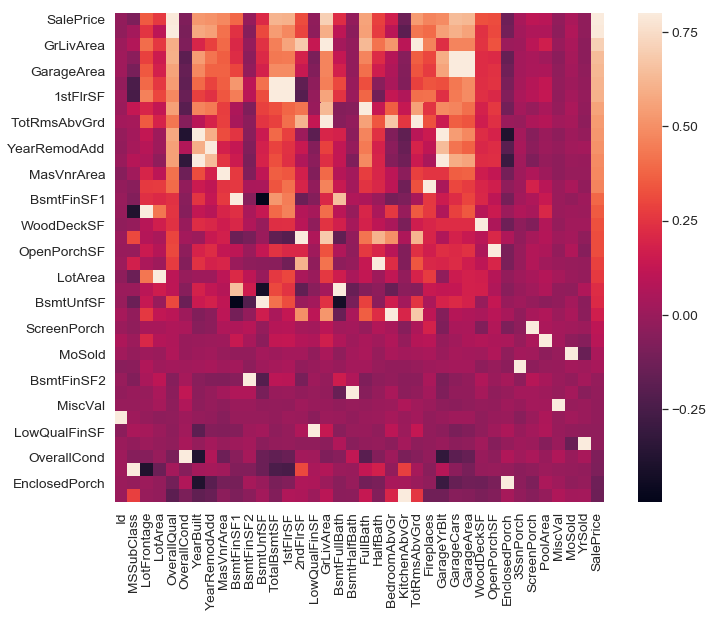

In [41]:
print("most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

# Dataset authur's recommended changes  
The author of the dataset recommends  removing any house more then 1200 sqfeet 

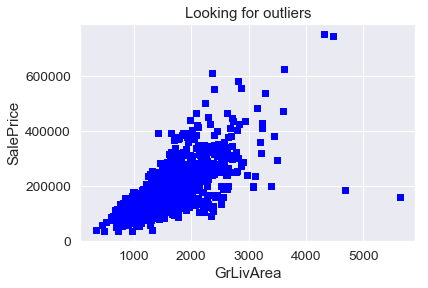

In [42]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

#train = train[train.GrLivArea < 4000]

# Skewness
Skewness is a measure of the shape of the distributed values. When working with regression we need to log transform the data to improve the linearity of the data. We will first log transform the data so when we get our result it will also be in log transformed state so we will need to revert them back to their original values by undoing log transformation. np. log() will transform our value and np.exp() will revert them back to their original format.

# Log of Dataset
Skewed data is cumbersome and common. It’s often desirable to transform skewed data and to convert it into values between 0 and 1.Standard functions used for such conversions include Normalization, the Sigmoid, Log, Cube Root and the Hyperbolic Tangent. It all depends on what one is trying to accomplish.

In [43]:
ntrain = train.shape[0]
ntest = test.shape[0]
train["SalePrice_log"] = np.log1p(train["SalePrice"]).astype(np.float64)
train_labels_with_OT=train["SalePrice_log"]
target=train["SalePrice_log"]

# Justifying my reason to take log of saleprice

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


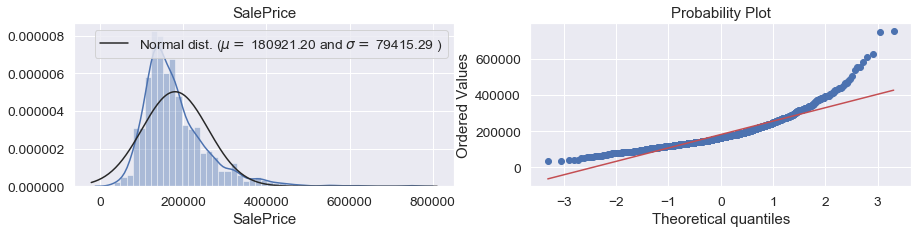

Skewness: 1.882876
Kurtosis: 6.536282


In [44]:
from scipy import stats
from scipy.stats import norm
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('SalePrice')

plt.subplot(122)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

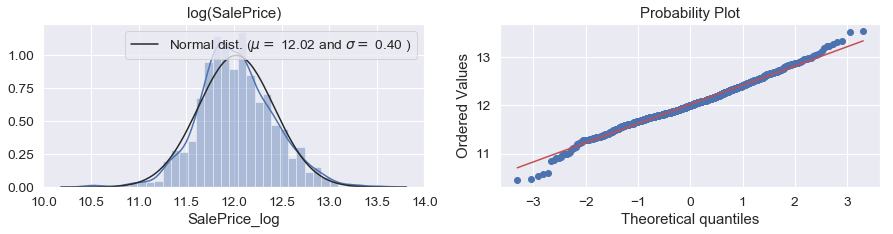

Skewness: 0.121347
Kurtosis: 0.809519


In [45]:
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train_labels_with_OT , fit=norm);

(mu, sigma) = norm.fit(train_labels_with_OT)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('log(SalePrice)')

plt.subplot(122)
res = stats.probplot(train_labels_with_OT, plot=plt)
plt.show()
print("Skewness: %f" % train["SalePrice_log"].skew())
print("Kurtosis: %f" % train["SalePrice_log"].kurt())

The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.We have verifed our assumption of skewness above as well.

# Numeric Features 


In [46]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
SalePrice_log    float64
dtype: object

# Catagorical Features

In [47]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


# Checking corellation  again
The first five features are the most positively correlated with SalePrice and the negative valued features are the least correlated. The graph shows the most correalted features.

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


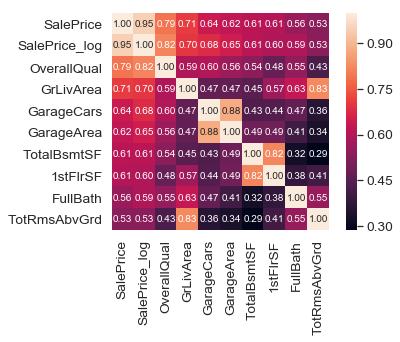

In [48]:
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Removing Outliers 

In [49]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

Let' check's the Garage area

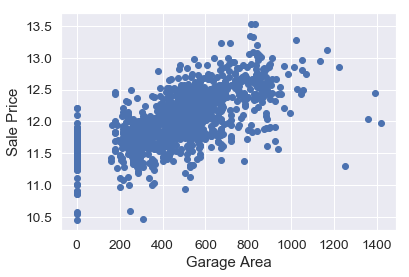

In [50]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [51]:
train = train[train['GarageArea'] < 1200]

After outliers removal

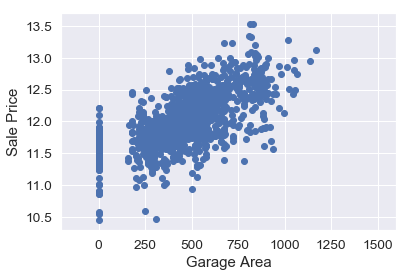

In [52]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

# Checking for missing data and handling

In [53]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageQual,81
GarageCond,81
GarageFinish,81


# Missing Data Ration

In [54]:
train_null = (train.isnull().sum() / len(train)) * 100
train_null = train_null.drop(train_null[train_null == 0].index).sort_values(ascending=False)[:]
missing_data = pd.DataFrame({'Missing Ratio' :train_null})
missing_data

,Missing Ratio
PoolQC,99.587629
MiscFeature,96.357388
Alley,93.745704
Fence,80.687285
FireplaceQu,47.353952
LotFrontage,17.731959
GarageYrBlt,5.567010
GarageType,5.567010
GarageFinish,5.567010
GarageQual,5.567010


Text(0.5, 1.0, 'Percent missing data by feature')

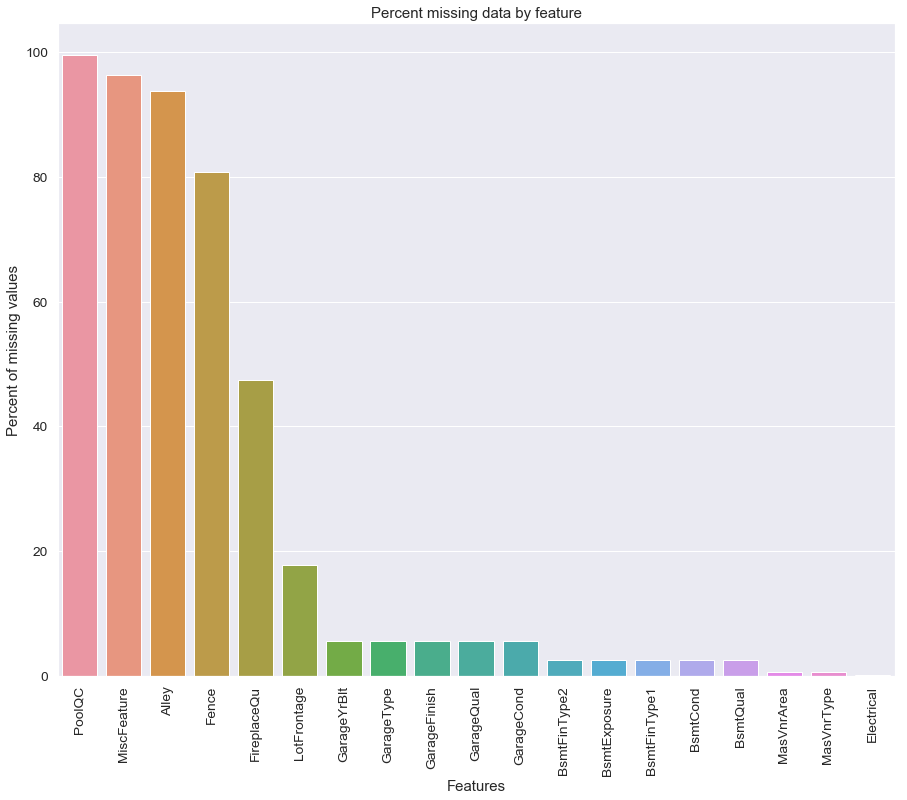

In [55]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_null.index, y=train_null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# Let's start filling missing data

In [56]:
print ("Original: \n") 
print (train.Street.value_counts(), "\n")

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



We will one-hot encode the Pave and Grvl so that we can work with these data. 

In [57]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [58]:
print ('Encoded: \n') 
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


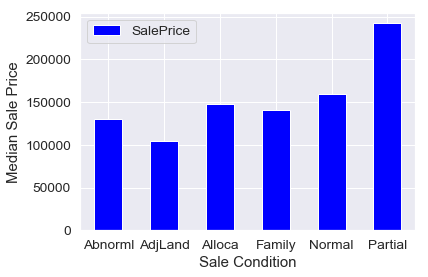

In [59]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [60]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

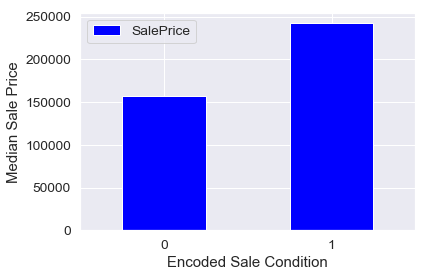

In [61]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

# Filling Numerical Data ( Interpolation ) 
We will use interpolation for the missing values. We will assign the average of that feature to te missing values. 

In [62]:
train_filled = train.select_dtypes(include=[np.number]).interpolate().dropna()
test_filled = test.select_dtypes(include=[np.number]).interpolate().dropna()


In [63]:
sum(train_filled.isnull().sum() != 0)
sum(test_filled.isnull().sum() != 0)

0

# Processing for Neural Network

In [64]:
y = np.log1p(train.SalePrice)
X = train_filled.drop(['SalePrice', 'Id','SalePrice_log'], axis=1)
Test = test_filled.drop(['Id'], axis=1)

In [65]:
Temp = X.select_dtypes(include=[np.number])
Temp.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
enc_street         uint8
enc_condition      int64
dtype: object

In [66]:
Temp2= Test.select_dtypes(include=[np.number])
Temp2.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
enc_street       float64
enc_condition      int64
dtype: object

In [67]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val= train_test_split(X, y, random_state=23, test_size=.20)

# First Model

In [68]:
import tensorflow as tf

tf.reset_default_graph()

num_steps =55500
beta = .005
hidden_1 = 16 
hidden_2 = 8
hidden_3 = 4 
input_dim = X_train_val.shape[1]
output_dim = 1  
X_tf = tf.placeholder("float" ) 
y_tf = tf.placeholder("float" ) 

In [69]:
#Learning rate with schedular
initial_learning_rate = 0.5
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

# Weights and Bias
Node: It is the basic unit of a neural network. It gets certain number of inputs and a bias value. When a signal(value) arrives, it gets multiplied by a weight value. If a neuron has 4 inputs, it has 4 weight values which can be adjusted during training time.<br /> 
Bias(ofset):It is an extra input to neurons and it is always 1, and has it’s own connection weight. This makes sure that even when all the inputs are none (all 0’s) there’s gonna be an activation in the neuron

In [70]:
weights = {'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),  
           'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),  
           'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])), 
           'out': tf.Variable(tf.random_normal([hidden_3, output_dim ])) }

biases = {'b1': tf.Variable(tf.random_normal([hidden_1])),
          'b2': tf.Variable(tf.random_normal([hidden_2])),
          'b3': tf.Variable(tf.random_normal([hidden_3])),
          'out': tf.Variable(tf.random_normal([output_dim])) } 

# Connections
It connects one neuron in one layer to another neuron in other layer or the same layer. A connection always has a weight value associated with it. Goal of the training is to update this weight value to decrease the loss(error).

# Activations
Activation functions are used to introduce non-linearity to neural networks. It squashes the values in a smaller range viz. a Sigmoid activation function squashes values between a range 0 to 1. There are many activation functions used in deep learning industry and ReLU, SeLU and TanH are preferred over sigmoid activation function.

In [71]:
def ann_model(X_val): 
        layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ]) 
        layer_1 = tf.nn.relu(layer_1) 
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2) 
        layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']) 
        layer_3 = tf.nn.relu(layer_3)
        layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases ['out'],name="layer_out") 
        return layer_out 

# Loss Function/Cost Function 
The loss function computes the error for a single training example. The cost function is the average of the loss functions of the entire training set.<br /> 
<br /> 
1.‘mse’: for mean squared error.<br /> 
2.‘binary_crossentropy’: for binary logarithmic loss (logloss).<br /> 
3.‘categorical_crossentropy’: for multi-class logarithmic loss (logloss).<br /> 
Here we used MSE

In [72]:
# Model Construct 
model = ann_model(X_tf) 
# Mean Squared Error cost function
loss= tf.reduce_mean(tf.square(y_tf - model)) 

# Regularization
It is used to overcome the over-fitting problem. In regularization we penalise our loss term by adding a L1 (LASSO) or an L2(Ridge) norm on the weight vector w (it is the vector of the learned parameters in the given algorithm).
L(Loss function) + λN(w) — here λ is your regularization term and N(w) is L1 or L2 norm. Here L2 is used.



In [73]:

regularizer_1 = tf.nn.l2_loss(weights['w1']) 
regularizer_2 = tf.nn.l2_loss(weights['w2']) 
regularizer_3 = tf.nn.l2_loss(weights['w3']) 
cost = tf.reduce_mean(loss + beta*regularizer_1 + beta*regularizer_2 
                      + regularizer_3)

# Model Optimizers
The optimizer is a search technique, which is used to update weights in the model.<br /> 

SGD: Stochastic Gradient Descent, with support for momentum.<br /> 

RMSprop: Adaptive learning rate optimization method proposed by Geoff Hinton.<br /> 

Adam: Adaptive Moment Estimation (Adam) that also uses adaptive learning rates<br /> 
Here we used Adam.

In [75]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost,global_step=global_step)

init = tf.global_variables_initializer() 
saver = tf.train.Saver() 

# Graph and Session
TensorFlow uses a dataflow graph to represent your computation in terms of the dependencies between individual operations. This leads to a low-level programming model in which you first define the dataflow graph, then create a TensorFlow session to run parts of the graph across a set of local and remote devices.



In [76]:
max_checks_without_progress = 1500
checks_without_progress = 0
best_loss = np.infty
with tf.Session() as sess: 
        sess.run(init) 
        for i in range(num_steps): 
            sess.run(training_op, feed_dict={X_tf:X_train_val, y_tf:y_train_val})  
            if (i+1)%100 == 0: 
                loss_val = cost.eval(feed_dict={X_tf: X_test_val, y_tf: y_test_val})
                print("batch no : ",i+1,"Loss",loss_val) 
                           #Check whether to stop or not
                if loss_val < best_loss:
                    save_path = saver.save(sess,"./Final_Certairi.ckpt")
                    best_loss = loss_val
                    checks_without_progress = 0
                else:
                    checks_without_progress += 1
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
        save_path = saver.save(sess, "/tmp/final2.ckpt") 
        print("Model saved in path: %s" % save_path) 
        pred = sess.run(model, feed_dict={X_tf:Test}) 
with tf.Session() as sess:
    saver.restore(sess, "./Final_Certairi.ckpt")
    pred = sess.run(model, feed_dict={X_tf:Test}) 


batch no :  100 Loss 357.70465
batch no :  200 Loss 354.2439
batch no :  300 Loss 351.1021
batch no :  400 Loss 348.23395
batch no :  500 Loss 345.40735
batch no :  600 Loss 342.47577
batch no :  700 Loss 339.3876
batch no :  800 Loss 336.1398
batch no :  900 Loss 332.74597
batch no :  1000 Loss 329.22266
batch no :  1100 Loss 325.58563
batch no :  1200 Loss 321.84894
batch no :  1300 Loss 318.02533
batch no :  1400 Loss 314.12576
batch no :  1500 Loss 310.16046
batch no :  1600 Loss 306.1383
batch no :  1700 Loss 302.06757
batch no :  1800 Loss 297.95557
batch no :  1900 Loss 293.80896
batch no :  2000 Loss 289.63394
batch no :  2100 Loss 285.43604
batch no :  2200 Loss 281.2204
batch no :  2300 Loss 276.9917
batch no :  2400 Loss 272.7544
batch no :  2500 Loss 268.51245
batch no :  2600 Loss 264.26965
batch no :  2700 Loss 260.0296
batch no :  2800 Loss 255.79572
batch no :  2900 Loss 251.57112
batch no :  3000 Loss 247.35876
batch no :  3100 Loss 243.1618
batch no :  3200 Loss 238.9

batch no :  25700 Loss 62.91057
batch no :  25800 Loss 62.735558
batch no :  25900 Loss 62.558323
batch no :  26000 Loss 62.3789
batch no :  26100 Loss 62.19718
batch no :  26200 Loss 62.01328
batch no :  26300 Loss 61.827187
batch no :  26400 Loss 61.638893
batch no :  26500 Loss 61.448402
batch no :  26600 Loss 61.255722
batch no :  26700 Loss 61.060936
batch no :  26800 Loss 60.864063
batch no :  26900 Loss 60.665115
batch no :  27000 Loss 60.464165
batch no :  27100 Loss 60.26118
batch no :  27200 Loss 60.056244
batch no :  27300 Loss 59.849304
batch no :  27400 Loss 59.640488
batch no :  27500 Loss 59.42979
batch no :  27600 Loss 59.21729
batch no :  27700 Loss 59.003014
batch no :  27800 Loss 58.78698
batch no :  27900 Loss 58.569195
batch no :  28000 Loss 58.34971
batch no :  28100 Loss 58.128624
batch no :  28200 Loss 57.905956
batch no :  28300 Loss 57.681725
batch no :  28400 Loss 57.455925
batch no :  28500 Loss 57.22862
batch no :  28600 Loss 56.999863
batch no :  28700 Los

batch no :  50800 Loss 27.535517
batch no :  50900 Loss 27.52573
batch no :  51000 Loss 27.516048
batch no :  51100 Loss 27.506668
batch no :  51200 Loss 27.497505
batch no :  51300 Loss 27.488424
batch no :  51400 Loss 27.479733
batch no :  51500 Loss 27.47115
batch no :  51600 Loss 27.46268
batch no :  51700 Loss 27.454597
batch no :  51800 Loss 27.44659
batch no :  51900 Loss 27.438673
batch no :  52000 Loss 27.431116
batch no :  52100 Loss 27.423674
batch no :  52200 Loss 27.41631
batch no :  52300 Loss 27.4092
batch no :  52400 Loss 27.40231
batch no :  52500 Loss 27.395458
batch no :  52600 Loss 27.388702
batch no :  52700 Loss 27.382294
batch no :  52800 Loss 27.375994
batch no :  52900 Loss 27.369738
batch no :  53000 Loss 27.363571
batch no :  53100 Loss 27.357758
batch no :  53200 Loss 27.352034
batch no :  53300 Loss 27.346336
batch no :  53400 Loss 27.340714
batch no :  53500 Loss 27.335339
batch no :  53600 Loss 27.33014
batch no :  53700 Loss 27.324999
batch no :  53800 L

In [83]:
 prediction = np.expm1(pred) 

In [84]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('submission_DNN_WD.csv',index=False)